Import modules and files

In [1]:
pip install optuna

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 209 kB 51.0 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 149 kB 43.7 MB/s 
     |████████████████████████████████| 112 kB 48.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=f926444cd91848e59bd12ab8d8a67388373ad264bb2bd8c3743de8bc5347b8ab
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import optuna
import random
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import DMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

random.seed(42)
np.random.seed(42)

In [3]:
sber = pd.read_csv('/content/drive/MyDrive/Pet/usd_prediction/quotes/SBER.csv')
gazp = pd.read_csv('/content/drive/MyDrive/Pet/usd_prediction/quotes/GAZP.csv')
br = pd.read_csv('/content/drive/MyDrive/Pet/usd_prediction/quotes/ICE_BRN.csv')
usd = pd.read_csv('/content/drive/MyDrive/Pet/usd_prediction/quotes/USD.csv')

quotes = [sber, gazp, br, usd]

In [4]:
sber.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,20180110,11:00:00,240.41,241.25,238.26,239.00,7577490
1,20180110,12:00:00,239.05,239.06,237.06,237.13,6306590
2,20180110,13:00:00,237.14,239.77,237.13,239.42,5271340
3,20180110,14:00:00,239.50,239.93,238.11,238.53,3220930
4,20180110,15:00:00,238.56,239.30,238.31,238.46,1962910


In [5]:
sber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11069 entries, 0 to 11068
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   <DATE>   11069 non-null  int64  
 1   <TIME>   11069 non-null  object 
 2   <OPEN>   11069 non-null  float64
 3   <HIGH>   11069 non-null  float64
 4   <LOW>    11069 non-null  float64
 5   <CLOSE>  11069 non-null  float64
 6   <VOL>    11069 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 605.5+ KB


In [6]:
for elem in quotes:
  elem['price_diff'] = (elem['<CLOSE>'] - elem['<OPEN>']) * 100 / elem['<OPEN>']
  elem['DATE_TIME'] = pd.to_datetime(elem['<DATE>'].astype('str') + ' ' + elem['<TIME>'])
  elem.set_index('DATE_TIME', inplace=True)

In [7]:
usd.head(5)

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,price_diff
DATE_TIME,,,,,,,,
2018-01-10 11:00:00,20180110,11:00:00,56.8875,57.0075,56.7625,56.9150,479255000,0.048341
2018-01-10 12:00:00,20180110,12:00:00,56.9200,56.9300,56.8125,56.9000,311507000,-0.035137
2018-01-10 13:00:00,20180110,13:00:00,56.9000,57.0250,56.8825,56.9800,397251000,0.140598
2018-01-10 14:00:00,20180110,14:00:00,56.9825,57.0950,56.9250,57.0375,418486000,0.096521
2018-01-10 15:00:00,20180110,15:00:00,57.0350,57.0675,56.9050,56.9300,387674000,-0.184097


In [8]:
for elem in quotes:
  elem.drop(['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>'], axis=1, inplace=True)
  elem.rename(columns={'<VOL>': 'VOL'}, inplace=True)
br.drop('VOL', axis=1, inplace=True)
usd.drop('VOL', axis=1, inplace=True)

In [9]:
usd.head()

,price_diff
DATE_TIME,
2018-01-10 11:00:00,0.048341
2018-01-10 12:00:00,-0.035137
2018-01-10 13:00:00,0.140598
2018-01-10 14:00:00,0.096521
2018-01-10 15:00:00,-0.184097


In [10]:
sber_gazp = sber.merge(gazp, how='inner', on='DATE_TIME', suffixes=['_sber', '_gazp'])
sber_gazp.head()

,VOL_sber,price_diff_sber,VOL_gazp,price_diff_gazp
DATE_TIME,,,,
2018-01-10 11:00:00,7577490,-0.586498,5913000,-0.021354
2018-01-10 12:00:00,6306590,-0.803179,7078190,0.320399
2018-01-10 13:00:00,5271340,0.961457,9191430,0.738112
2018-01-10 14:00:00,3220930,-0.405010,6300360,-0.049320
2018-01-10 15:00:00,1962910,-0.041918,2535980,0.056394


In [11]:
br_usd = br.merge(usd, how='inner', on='DATE_TIME', suffixes=['_br', '_usd'])

In [12]:
data = sber_gazp.merge(br_usd, how='inner', on='DATE_TIME')

In [13]:
names = ['sber', 'gazp', 'br', 'usd']
for name in names:
  data.rename(columns={'price_diff_' + name: name}, inplace=True)

In [14]:
data.head(20)

,VOL_sber,sber,VOL_gazp,gazp,br,usd
DATE_TIME,,,,,,
2018-01-10 11:00:00,7577490,-0.586498,5913000,-0.021354,0.014470,0.048341
2018-01-10 12:00:00,6306590,-0.803179,7078190,0.320399,0.086793,-0.035137
2018-01-10 13:00:00,5271340,0.961457,9191430,0.738112,-0.216826,0.140598
2018-01-10 14:00:00,3220930,-0.405010,6300360,-0.049320,0.072422,0.096521
2018-01-10 15:00:00,1962910,-0.041918,2535980,0.056394,0.188160,-0.184097
2018-01-10 16:00:00,2326560,-0.159356,2685660,0.021139,0.115574,0.144915
2018-01-10 17:00:00,3118850,-0.109225,5741970,0.394589,-0.202049,-0.026309
2018-01-10 18:00:00,4182490,-0.155580,7420520,0.301797,-0.216951,0.000000
2018-01-10 19:00:00,5386350,0.130554,4889330,0.363865,-0.028986,-0.052641


In [15]:
y = data[['usd']].shift(periods=1).dropna()

In [16]:
y.head(20)

,usd
DATE_TIME,
2018-01-10 12:00:00,0.048341
2018-01-10 13:00:00,-0.035137
2018-01-10 14:00:00,0.140598
2018-01-10 15:00:00,0.096521
2018-01-10 16:00:00,-0.184097
2018-01-10 17:00:00,0.144915
2018-01-10 18:00:00,-0.026309
2018-01-10 19:00:00,0.000000
2018-01-11 11:00:00,-0.052641


In [17]:
X = data.iloc[1:,:]

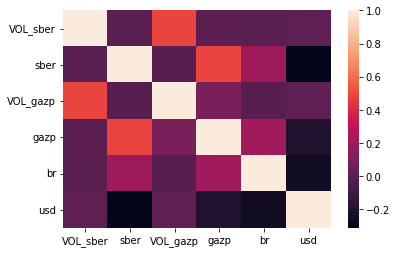

In [18]:
sns.heatmap(X.corr(), xticklabels=X.columns, yticklabels=X.columns)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [20]:
y_test

,usd
DATE_TIME,
2019-01-15 17:00:00,-0.007452
2021-05-25 21:00:00,-0.010207
2019-09-10 14:00:00,-0.053429
2021-05-21 16:00:00,0.044252
2019-12-27 18:00:00,0.137130
...,...
2019-05-08 14:00:00,-0.019156
2021-10-01 12:00:00,-0.072012
2021-03-10 12:00:00,-0.006754


In [21]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
preds = []
scores = []
for fold, (idx_train_k, idx_valid_k) in enumerate(kf.split(X_train, y_train)):
    X_train_k, y_train_k = X_train.iloc[idx_train_k], y_train.iloc[idx_train_k]
    X_valid_k, y_valid_k = X_train.iloc[idx_valid_k], y_train.iloc[idx_valid_k]
    model = XGBRegressor(n_jobs=4, 
                         seed=42,
                         objective='reg:squarederror',
                         eval_metric='mae', 
                         n_estimators=1000)
    
    model.fit(X_train_k, y_train_k, eval_set=[(X_valid_k,y_valid_k)],
            early_stopping_rounds=100, verbose=500)
    
    pred_valid = model.predict(X_valid_k)
    score = mean_absolute_error(y_valid_k, pred_valid)
    scores.append(score)
    
    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print('||'*40, "\n")
    
    test_preds = model.predict(X_test)
    preds.append(test_preds)
    
print(f"Overall Validation Score: {np.mean(scores)}")

[0]	validation_0-mae:0.456631
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[52]	validation_0-mae:0.125953

Fold: 1 Score: 0.12595314309986771

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

[0]	validation_0-mae:0.455683
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[48]	validation_0-mae:0.130828

Fold: 2 Score: 0.13082752342996518

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

[0]	validation_0-mae:0.449922
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[40]	validation_0-mae:0.120618

Fold: 3 Score: 0.12061755754041073

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

[0]	validation_0-mae:0.448861
Will train until validation_0-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[40]	validation_0-mae:0.1299

Fold: 4 Score: 0.1298997507191968

In [22]:
def objective(trial):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    preds = []
    scores = []

    param = {
        'seed': 42,
        'nthread': 4,
        "silent": 0,
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        'n_estimators': 10000,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 20)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        param['colsample_bytree'] = trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0)
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-mae")
    #model = XGBRegressor(**param)

    for fold, (idx_train_k, idx_valid_k) in enumerate(kf.split(X_train, y_train)):
      X_train_k, y_train_k = X_train.iloc[idx_train_k], y_train.iloc[idx_train_k]
      X_valid_k, y_valid_k = X_train.iloc[idx_valid_k], y_train.iloc[idx_valid_k]
      #dtrain = DMatrix(X_train_k, label=y_train_k)
      #dtest = DMatrix(X_valid_k, label=y_valid_k)
      model = XGBRegressor(**param)
      model.fit(X_train_k, y_train_k, eval_set=[(X_valid_k, y_valid_k)], early_stopping_rounds=100, verbose=0)
      pred_valid = model.predict(X_valid_k)
      score = mean_absolute_error(y_valid_k, pred_valid)
      scores.append(score)
    return np.mean(scores)

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, timeout=3600)

[I 2022-01-12 08:18:22,662] A new study created in memory with name: no-name-9cfce204-b696-4e5a-8372-96007c8cef3f
[I 2022-01-12 08:18:35,403] Trial 0 finished with value: 0.13049455264219598 and parameters: {'booster': 'gbtree', 'lambda': 0.04592984893832288, 'alpha': 4.9198420948657807e-05, 'max_depth': 10, 'eta': 0.005505493130417911, 'gamma': 8.62727621199002e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 2.325037333102637e-05}. Best is trial 0 with value: 0.13049455264219598.
[I 2022-01-12 08:18:41,259] Trial 1 finished with value: 0.12769885088242966 and parameters: {'booster': 'gbtree', 'lambda': 0.009468963556199078, 'alpha': 0.014834370062189146, 'max_depth': 1, 'eta': 3.8465842006455674e-05, 'gamma': 0.004595359537879744, 'grow_policy': 'depthwise', 'colsample_bytree': 6.498722419989753e-06}. Best is trial 1 with value: 0.12769885088242966.
[I 2022-01-12 08:18:47,560] Trial 2 finished with value: 0.12915333648719046 and parameters: {'booster': 'gbtree', 'lambda': 0.05364

In [24]:
print('Best trial:', study.best_trial.params)

Best trial: {'booster': 'dart', 'lambda': 5.3950990315147695e-08, 'alpha': 5.167774751205662e-06, 'max_depth': 1, 'eta': 0.7911582739308235, 'gamma': 0.5265599966303861, 'grow_policy': 'depthwise', 'colsample_bytree': 0.7145496525120356, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00010655805918359706, 'skip_drop': 0.000457389288745382}


In [25]:
optuna.visualization.plot_optimization_history(study)

In [26]:
optuna.visualization.plot_param_importances(study)

In [32]:
params = study.best_params
print(params)

{'booster': 'dart', 'lambda': 5.3950990315147695e-08, 'alpha': 5.167774751205662e-06, 'max_depth': 1, 'eta': 0.7911582739308235, 'gamma': 0.5265599966303861, 'grow_policy': 'depthwise', 'colsample_bytree': 0.7145496525120356, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00010655805918359706, 'skip_drop': 0.000457389288745382}


In [33]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
preds = []
scores = []
for fold, (idx_train_k, idx_valid_k) in enumerate(kf.split(X_train, y_train)):
    X_train_k, y_train_k = X_train.iloc[idx_train_k], y_train.iloc[idx_train_k]
    X_valid_k, y_valid_k = X_train.iloc[idx_valid_k], y_train.iloc[idx_valid_k]
    model = XGBRegressor(**params)
    
    model.fit(X_train_k, y_train_k, eval_set=[(X_valid_k,y_valid_k)],
            early_stopping_rounds=100, verbose=500)
    
    pred_valid = model.predict(X_valid_k)
    score = mean_absolute_error(y_valid_k, pred_valid)
    scores.append(score)
    
    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print('||'*40, "\n")
    
    test_preds = model.predict(X_test)
    preds.append(test_preds)
    
print(f"Overall Validation Score: {np.mean(scores)}")

[09:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.487633
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:0.181798
Fold: 1 Score: 0.12371864545443584

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

[09:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.497141
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:0.229575
Fold: 2 Score: 0.13141550135365013

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

[09:21:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.477599
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:0.1

In [37]:
y_pred = (np.mean(preds, axis=0))

In [42]:
y_test

,usd
DATE_TIME,
2019-01-15 17:00:00,-0.007452
2021-05-25 21:00:00,-0.010207
2019-09-10 14:00:00,-0.053429
2021-05-21 16:00:00,0.044252
2019-12-27 18:00:00,0.137130
...,...
2019-05-08 14:00:00,-0.019156
2021-10-01 12:00:00,-0.072012
2021-03-10 12:00:00,-0.006754


In [51]:
comp_df = pd.DataFrame()
comp_df['test'] = y_test.usd
comp_df['pred'] = y_pred
comp_df['diff'] = comp_df.test - comp_df.pred

In [52]:
comp_df.head(20)

,test,pred,diff
DATE_TIME,,,
2019-01-15 17:00:00,-0.007452,0.015997,-0.023449
2021-05-25 21:00:00,-0.010207,0.002941,-0.013148
2019-09-10 14:00:00,-0.053429,0.002941,-0.056370
2021-05-21 16:00:00,0.044252,0.005119,0.039133
2019-12-27 18:00:00,0.137130,0.016658,0.120472
2021-07-22 18:00:00,-0.094761,0.002941,-0.097702
2021-12-27 10:00:00,-0.003400,0.012313,-0.015713
2018-06-11 19:00:00,0.167893,-0.002074,0.169967
2020-05-19 19:00:00,-0.100117,0.031687,-0.131804


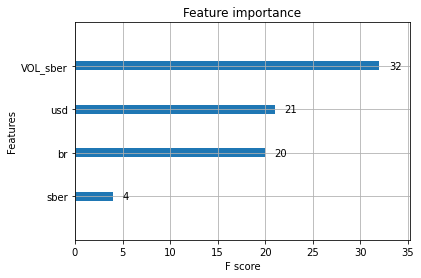

In [55]:
from xgboost import plot_importance
plot_importance(model)